#Modern Computer Vision Assignment 1:  Report 


# Importing Necessory Libraries

In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sklearn.metrics
import torch.nn as nn
import torch.nn.functional as F
import time
import sys
import os
import gc
import numpy as np
import PIL.Image



In [2]:
# Checking if cuda available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Defining Hyperparameters and Necessary Global Variables


In [3]:
epochs = 10
learningRate = 0.01
inputs = 3*32*32
noOfNodesL1 = 500
noOfNodesL2 = 250
noOfNodesL3 = 100
outputs = 10
batchSize = 100
outputLabel = {0: 'airplane' , 1: 'automobile' , 2: 'bird' , 3: 'cat' , 4: 'deer' , 5: 'dog' , 6: 'frog' , 7: 'horse' , 8: 'ship' , 9: 'truck'}

# Helpful Functions

In [4]:
def displayImages2(data , model ,device=torch.device("cuda" if torch.cuda.is_available() else "cpu") ):
  """
  Displaying 'numberOfImages' Random Images
  numberOfImages - Even Number
  """
  ix=1
  fig, ax = plt.subplots(10, 5, figsize=(15,15))
  fig.tight_layout()
  model.eval()
  for filter in range(50):
    randInt = torch.randint(0 , 10000 , (1,))
    #print(randInt)
    #randInt = 1
    ax = plt.subplot(10, 5, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    image , target = data[int(randInt)]
    temp = image.cpu()
    image = torch.reshape(image , (1 , 3 , 32 , 32))
    image = image.to(device)
    temp = torch.clamp(temp , 0 , 1)
    out = model(image)
    yPred = F.softmax(out , dim =1)
    predictedNumber = torch.argmax(yPred , dim = 1)
    ax.title.set_text('P | R: {}|{}'.format(outputLabel[int(predictedNumber)] , outputLabel[int(target)]))
    plt.imshow(temp.T)
    ix+=1

In [15]:
def loadDataSetPy(): # Loading DataSet for pyTorch
  """
  60k Train Data in batches of "batchSize"
  10k Test Data
  Also Does Appropriate Transformations Required
  """
  train_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
  
  test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
  
  train = torchvision.datasets.CIFAR10('./data' , train=True, transform= train_transform, download=True)
  
  testData = torchvision.datasets.CIFAR10('./data' , train=False, transform= test_transform,  download = True)
  trainData, validData = torch.utils.data.random_split(train, [45000, 5000])
  
  trainDataLoader = DataLoader(trainData , batch_size = batchSize , shuffle = True)
  testDataLoader = DataLoader(trainData , batch_size = 10000 , shuffle = True)
  validDataLoader = DataLoader(validData, batch_size = 5000 , shuffle = True , num_workers = 2)
  
  return trainDataLoader , testDataLoader , trainData, validDataLoader, testData


In [104]:
# Defining the MLP

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(inputs, noOfNodesL1) 
        self.l2 = nn.Linear(noOfNodesL1, noOfNodesL2)
        self.l3 = nn.Linear(noOfNodesL2 , noOfNodesL3)
        self.l4 = nn.Linear(noOfNodesL3 , outputs)
    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.l4(out)
        # no activation and no4softmax at the end
        return out

In [6]:
def creatingOutputVector(trainLabels):
  """
  trainLabels - Labels of Input Train Data of a Partiular Batch. (Size: batchSize X 1)
  yReal - True Output. Size: (batchSize X 10)
  """
  batchSize = len(trainLabels)
  yReal = np.zeros([batchSize , 10]) # BatchSize X 10 Matrix
  for j in range(batchSize):
    yReal[j][trainLabels[j]] = 1
  return yReal

In [106]:
def predictPy(testDataLoader , model):
  for data in testDataLoader:
    img , label = data
  X = torch.reshape(img , (len(img) , 32*32*3))
  model.eval()
  yPred = F.softmax(model(X) , dim =1)
  predictedNumber = torch.argmax(yPred , dim = 1)
  noOfRightPrediction = torch.sum(predictedNumber == label)
  totalPrediction = len(img)
  accuracy = noOfRightPrediction/totalPrediction
  confusionMatrix = sklearn.metrics.confusion_matrix( label , predictedNumber)



  return accuracy , confusionMatrix

In [5]:
def predictPyCNN(testDataLoader , model , device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
  if device == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
  for data in testDataLoader:
    img , label = data
  X = torch.reshape(img , (len(img) , 3 , 32 , 32))
  X = X.to(device)
  label = label.to(device)
  model.eval()
  yPred = F.softmax(model(X) , dim =1)
  predictedNumber = torch.argmax(yPred , dim = 1)
  noOfRightPrediction = torch.sum(predictedNumber == label)
  totalPrediction = len(img)
  accuracy = noOfRightPrediction/totalPrediction

  confusionMatrix = sklearn.metrics.confusion_matrix( label.cpu() , predictedNumber.cpu())



  return accuracy , confusionMatrix

In [13]:
def displayImages(data , model):
  """
  Displaying 32 Random Images
  """
  ix=1
  fig, ax = plt.subplots(8, 4, figsize=(10,10))
  fig.tight_layout()
  model.eval()
  for filter in range(32):
    randInt = torch.randint(0 , 10000 , (1,))
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    image , target = data[int(randInt)]
    temp = image
    temp = torch.clamp(temp , 0 , 1)
    image = torch.reshape(image , (1 , 32*32*3))
    out = model(image)
    yPred = F.softmax(out , dim =1)
    predictedNumber = torch.argmax(yPred , dim = 1)
    ax.title.set_text('P | R: {}|{}'.format(outputLabel[int(predictedNumber)] , outputLabel[int(target)]))
    plt.imshow(temp.T)
    ix+=1

# Training The Model

In [16]:
"""
Loading Datasets
"""
trainDataLoader , testDataLoader , trainData, validDataLoader, testData = loadDataSetPy()

Files already downloaded and verified
Files already downloaded and verified


Epoch 0 
Cost After Mini Batch 0: 2.311132
Cost After Mini Batch 100: 1.840939
Cost After Mini Batch 200: 1.781129
Cost After Mini Batch 300: 1.528851
Cost After Mini Batch 400: 1.555144
After Epoch 0, Validation accuracy = 45.41999816894531


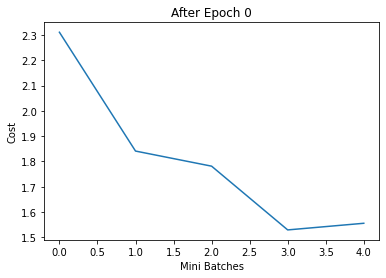

Epoch 1 
Cost After Mini Batch 0: 1.539053
Cost After Mini Batch 100: 1.522800
Cost After Mini Batch 200: 1.427155
Cost After Mini Batch 300: 1.646216
Cost After Mini Batch 400: 1.561159
After Epoch 1, Validation accuracy = 49.119998931884766


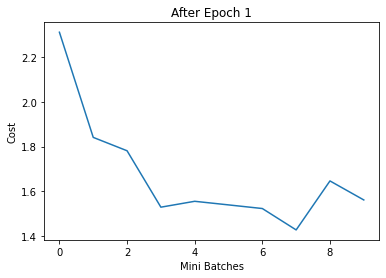

Epoch 2 
Cost After Mini Batch 0: 1.298357
Cost After Mini Batch 100: 1.293602
Cost After Mini Batch 200: 1.274947
Cost After Mini Batch 300: 1.341696
Cost After Mini Batch 400: 1.179518
After Epoch 2, Validation accuracy = 51.279998779296875


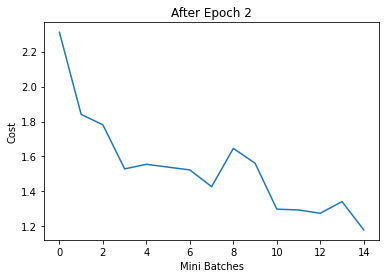

Epoch 3 
Cost After Mini Batch 0: 1.132018
Cost After Mini Batch 100: 1.164940
Cost After Mini Batch 200: 1.283786
Cost After Mini Batch 300: 1.429813
Cost After Mini Batch 400: 1.348689
After Epoch 3, Validation accuracy = 51.12000274658203


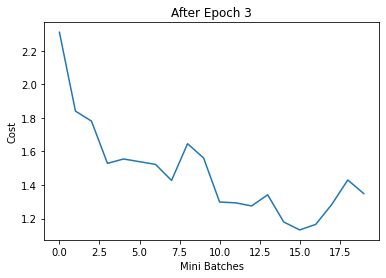

Epoch 4 
Cost After Mini Batch 0: 1.331268
Cost After Mini Batch 100: 1.043499
Cost After Mini Batch 200: 1.116550
Cost After Mini Batch 300: 0.997852
Cost After Mini Batch 400: 1.110326
After Epoch 4, Validation accuracy = 52.439998626708984


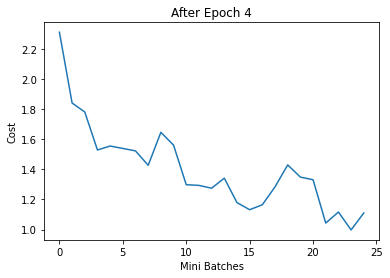

Epoch 5 
Cost After Mini Batch 0: 1.114824
Cost After Mini Batch 100: 1.015516
Cost After Mini Batch 200: 0.964952
Cost After Mini Batch 300: 1.227359
Cost After Mini Batch 400: 1.299149
After Epoch 5, Validation accuracy = 52.70000076293945


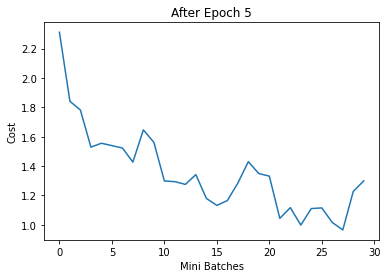

Epoch 6 
Cost After Mini Batch 0: 1.053469
Cost After Mini Batch 100: 1.139132
Cost After Mini Batch 200: 0.929680
Cost After Mini Batch 300: 0.970843
Cost After Mini Batch 400: 1.123901
After Epoch 6, Validation accuracy = 53.70000076293945


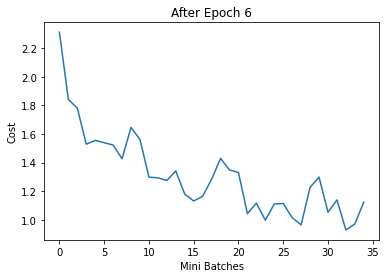

Epoch 7 
Cost After Mini Batch 0: 0.813730
Cost After Mini Batch 100: 0.882246
Cost After Mini Batch 200: 1.048999
Cost After Mini Batch 300: 0.952442
Cost After Mini Batch 400: 1.137312
After Epoch 7, Validation accuracy = 52.78000259399414


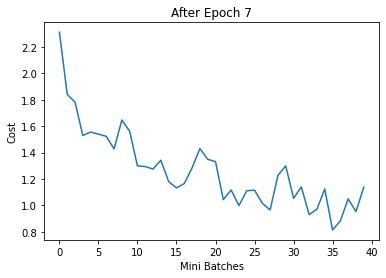

Epoch 8 
Cost After Mini Batch 0: 0.865818
Cost After Mini Batch 100: 0.702905
Cost After Mini Batch 200: 0.904021
Cost After Mini Batch 300: 0.857858
Cost After Mini Batch 400: 0.872158
After Epoch 8, Validation accuracy = 52.619998931884766


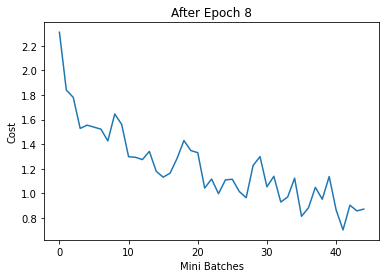

Epoch 9 
Cost After Mini Batch 0: 0.748782
Cost After Mini Batch 100: 0.712571
Cost After Mini Batch 200: 0.846918
Cost After Mini Batch 300: 0.804748
Cost After Mini Batch 400: 1.026457
After Epoch 9, Validation accuracy = 53.500003814697266


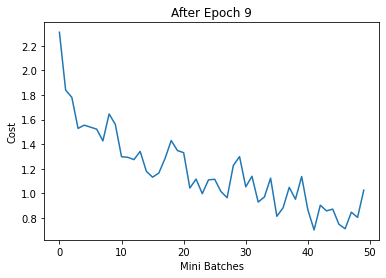

Execution Time --- 171.6047477722168 seconds ---


In [9]:
"""
Intilizing the model
"""
model = NeuralNet()
optim = torch.optim.SGD(model.parameters(), lr=learningRate , momentum = 0.9)
criterion = nn.CrossEntropyLoss()

"""
Training
"""
start_time = time.time()
n_total_steps = batchSize
totalCost = []
model.train()
for epoch in range(epochs):
  print('Epoch {} '.format(epoch))
  for i , (images,labels) in enumerate(trainDataLoader):
    # FLATTENING
    images = torch.reshape(images , (batchSize , 3072)) # Size : [batchSize X 3072]
    # FORWARD PASS
    yPred = model(images)
    loss = criterion(yPred , labels)

    # OPTIMISATION
    optim.zero_grad()
    loss.backward()
    optim.step()
    cost = loss.item()
    if i%100 == 0:
      print('Cost After Mini Batch %i: %f' %(i , cost))
      totalCost.append(loss.item())
  model.eval()
  accuracy, confusionMatrix = predictPy(validDataLoader , model)
  print('After Epoch {}, Validation accuracy = {}'.format(epoch , accuracy*100))
  plt.plot(totalCost)
  plt.title('After Epoch {}'.format(epoch))
  plt.xlabel('Mini Batches')
  plt.ylabel('Cost')
  plt.show()
print("Execution Time --- %s seconds ---" % (time.time() - start_time))

    
      


# Confusion Matrix

In [10]:
accuracy , confusionMatrix = predictPy(testDataLoader , model)
print('Accuracy on Test Data = {}%'.format(accuracy*100))
print('Confusion Matrix on Test Data')
print(confusionMatrix)

Accuracy on Test Data = 73.6199951171875%
Confusion Matrix on Test Data
[[349  10  27  12  24   4   4   3  43  22]
 [  3 434   5   7   6   3   6   2  24  45]
 [ 21   1 263  50  67  23  27   9   5   2]
 [  7   2  28 306  26  85  23  11   6   6]
 [ 11   5  28  21 383   4  37  11   6   3]
 [  5   1  15  82  27 347  14   8   1   3]
 [  2   3  13  41  28   8 394   3   0   3]
 [  5   2   6  25  57  22   3 369   4   8]
 [ 21  27   4  11   8   1   2   0 423  12]
 [  5  29   3  11   6   4   2   3   6 413]]


# Plotting Randomly Selected Images 
- Without Batch Normalization
- P : Predicted Class, R : Real Class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


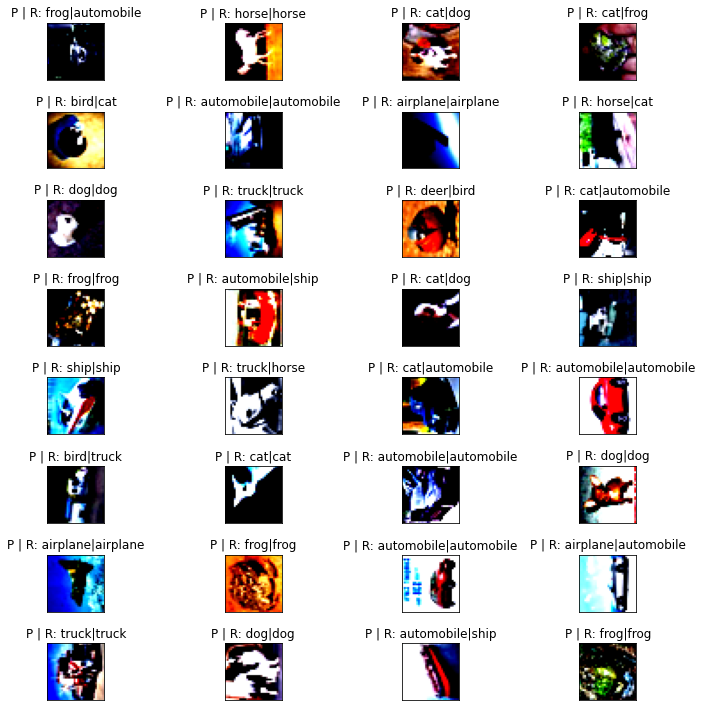

In [12]:
displayImages(testData , model)

# With Batch Normalization

In [ ]:

class NeuralNetWithBN(nn.Module):
    def __init__(self):
        super(NeuralNetWithBN, self).__init__()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(inputs, noOfNodesL1)
        self.b1 = nn.BatchNorm1d(noOfNodesL1) 
        self.l2 = nn.Linear(noOfNodesL1, noOfNodesL2)
        self.b2 = nn.BatchNorm1d(noOfNodesL2)
        self.l3 = nn.Linear(noOfNodesL2 , noOfNodesL3)
        self.b3 = nn.BatchNorm1d(noOfNodesL3)
        self.l4 = nn.Linear(noOfNodesL3 , outputs)
    def forward(self, x):
        out = self.relu(self.b1(self.l1(x)))
        out = self.relu(self.b2(self.l2(out)))
        out = self.relu(self.b3(self.l3(out)))
        out = self.l4(out)
        # no activation and no4softmax at the end
        return out

Epoch 0 
Cost After Mini Batch 0: 2.383224
Cost After Mini Batch 100: 1.700450
Cost After Mini Batch 200: 1.453422
Cost After Mini Batch 300: 1.522559
Cost After Mini Batch 400: 1.391195
After Epoch 0, Validation accuracy = 48.5


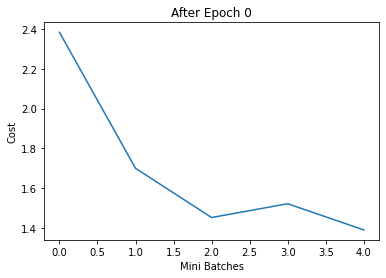

Epoch 1 
Cost After Mini Batch 0: 1.582003
Cost After Mini Batch 100: 1.543284
Cost After Mini Batch 200: 1.427740
Cost After Mini Batch 300: 1.199081
Cost After Mini Batch 400: 1.192501
After Epoch 1, Validation accuracy = 48.97999954223633


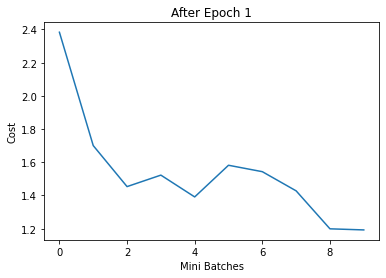

Epoch 2 
Cost After Mini Batch 0: 1.375597
Cost After Mini Batch 100: 1.322512
Cost After Mini Batch 200: 1.235305
Cost After Mini Batch 300: 1.281783
Cost After Mini Batch 400: 1.109986
After Epoch 2, Validation accuracy = 49.63999938964844


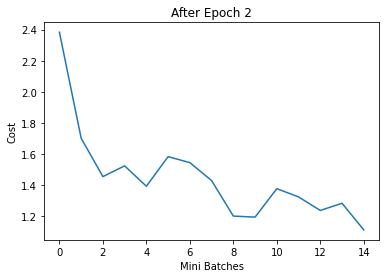

Epoch 3 
Cost After Mini Batch 0: 1.221174
Cost After Mini Batch 100: 0.979037
Cost After Mini Batch 200: 1.143501
Cost After Mini Batch 300: 1.254964
Cost After Mini Batch 400: 1.385743
After Epoch 3, Validation accuracy = 52.47999954223633


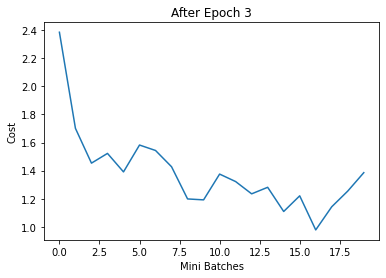

Epoch 4 
Cost After Mini Batch 0: 1.100049
Cost After Mini Batch 100: 1.069984
Cost After Mini Batch 200: 0.944833
Cost After Mini Batch 300: 1.088776
Cost After Mini Batch 400: 1.249971
After Epoch 4, Validation accuracy = 52.439998626708984


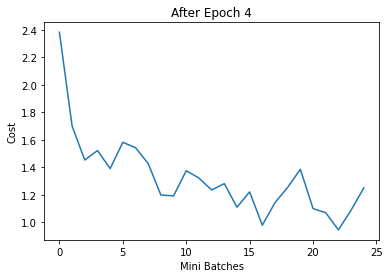

Epoch 5 
Cost After Mini Batch 0: 1.051230
Cost After Mini Batch 100: 1.046620
Cost After Mini Batch 200: 1.222595
Cost After Mini Batch 300: 1.061490
Cost After Mini Batch 400: 1.140897
After Epoch 5, Validation accuracy = 55.159996032714844


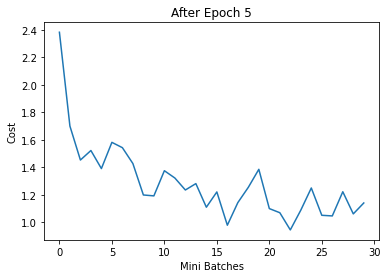

Epoch 6 
Cost After Mini Batch 0: 0.843136
Cost After Mini Batch 100: 1.013773
Cost After Mini Batch 200: 0.947004
Cost After Mini Batch 300: 0.942487
Cost After Mini Batch 400: 0.951548
After Epoch 6, Validation accuracy = 54.07999801635742


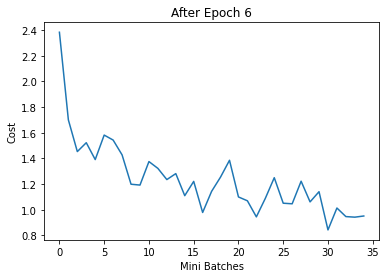

Epoch 7 
Cost After Mini Batch 0: 0.792948
Cost After Mini Batch 100: 0.656006
Cost After Mini Batch 200: 1.014510
Cost After Mini Batch 300: 1.006602
Cost After Mini Batch 400: 0.933423
After Epoch 7, Validation accuracy = 53.820003509521484


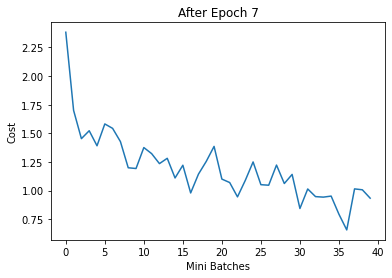

Epoch 8 
Cost After Mini Batch 0: 0.858434
Cost After Mini Batch 100: 0.785785
Cost After Mini Batch 200: 0.913952
Cost After Mini Batch 300: 0.749897
Cost After Mini Batch 400: 1.099093
After Epoch 8, Validation accuracy = 53.15999984741211


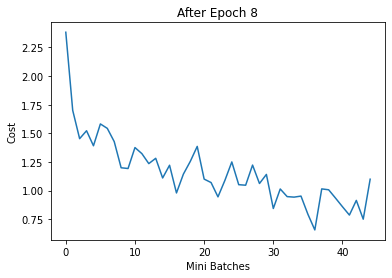

Epoch 9 
Cost After Mini Batch 0: 0.894441
Cost After Mini Batch 100: 0.662178
Cost After Mini Batch 200: 0.641659
Cost After Mini Batch 300: 0.810018
Cost After Mini Batch 400: 0.655432
After Epoch 9, Validation accuracy = 53.96000289916992


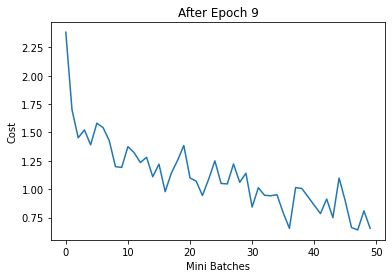

Execution Time --- 225.135009765625 seconds ---


In [ ]:
"""
Intilizing the model
"""
modelWithBN = NeuralNetWithBN()
optim = torch.optim.SGD(modelWithBN.parameters(), lr=learningRate , momentum = 0.9)
criterion = nn.CrossEntropyLoss()

"""
Training
"""
modelWithBN.train()
start_time = time.time()
n_total_steps = batchSize
totalCost = []
for epoch in range(epochs):
  print('Epoch {} '.format(epoch))
  for i , (images,labels) in enumerate(trainDataLoader):
    # FLATTENING
    images = torch.reshape(images , (batchSize , 3072)) # Size : [batchSize X 3072]
    # FORWARD PASS
    yPred = modelWithBN(images)
    loss = criterion(yPred , labels)

    # OPTIMISATION
    optim.zero_grad()
    loss.backward()
    optim.step()
    cost = loss.item()
    if i%100 == 0:
      print('Cost After Mini Batch %i: %f' %(i , cost))
      totalCost.append(loss.item())
  modelWithBN.eval()
  accuracy, confusionMatrix = predictPy(validDataLoader , modelWithBN)
  print('After Epoch {}, Validation accuracy = {}'.format(epoch , accuracy*100))
  plt.plot(totalCost)
  plt.title('After Epoch {}'.format(epoch))
  plt.xlabel('Mini Batches')
  plt.ylabel('Cost')
  plt.show()
print("Execution Time --- %s seconds ---" % (time.time() - start_time))

    
      


# Confusion Matrix 

In [ ]:
accuracy , confusionMatrix = predictPy(testDataLoader , modelWithBN)
print('Accuracy on Test Data = {}%'.format(accuracy*100))
print('Confusion Matrix on Test Data')
print(confusionMatrix)

Accuracy on Test Data = 76.5%
Confusion Matrix on Test Data
[[437  11  13   2   5   3   5   8  21  10]
 [ 13 401   5   1   2   2   6   0   6  43]
 [ 29   5 302  34  34  16  33  12   3   4]
 [ 13   9  27 337  14  77  36  17   2   7]
 [ 17   5  41  17 350  13  22  23   1   2]
 [  5   3  26  81   9 340   8  24   1   1]
 [  4   1   8  21  13   5 443   1   0   1]
 [ 11   2  10  12  12  26   5 420   2   3]
 [ 72  24  10   5   7   7   3   2 368  12]
 [ 14  22   5   5   4   8   1   5   5 427]]


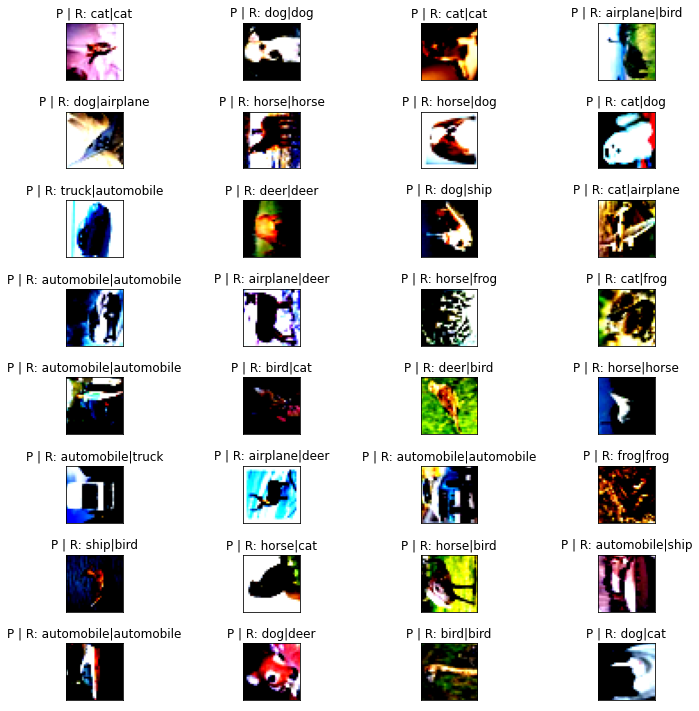

In [ ]:
displayImages(testData , modelWithBN)

# Report
1. Prediction Accuracy on Test Data (Without Batch Normalization) - 73.6%

    Prediction Accuracy on Test Data (With Batch Normalization) - 76.5 %

2. **Use batch-normalization. Does it improve the test accuracy? Does it affect training time?**
    
    Yes as seen, from above, Batch Normalization has improved the accuracy by a small margin. Maybe this can also be associated with the initialization of weights. 

    Execution Time

  With Batch Normalization - 225.14 secs

  Without BN - 171.60 secs

  We can see a considerable increase in Execution Time


# CNN

Loading Datasets and Performing Necessory Transformations

In [6]:
train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dset = torchvision.datasets.CIFAR10(root="data/", train=True, transform=train_transform, download=True)
test_dset = torchvision.datasets.CIFAR10(root="data/", train=False, transform=test_transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [7]:
train_loader = DataLoader(train_dset, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=100, shuffle=False, num_workers=2)


Defining the Architecture

In [8]:
class VGG(nn.Module):
  CONFIGS = {
      "vgg11": [64, "pool", 128, "pool", 256, 256, "pool", 512, 512, "pool", 512, 512, "pool"],
  }
  def __init__(self, cfg):
    super(VGG, self).__init__()
    in_dim = 3
    layers = []
    for layer in self.CONFIGS[cfg]:
        if layer == "pool":
            maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
            layers.append(maxpool)
        else:
            block = nn.Sequential(nn.Conv2d(in_dim , layer , kernel_size = 3 , padding = 1),
                                  nn.BatchNorm2d(layer),
                                  nn.ReLU())
            layers.append(block)
            in_dim = layer
    avgpool = nn.AvgPool2d(kernel_size=1)
    layers.append(avgpool)
    self.layers = nn.Sequential(*layers)
    self.fc1 = nn.Linear(512, 100)
    self.fc2 = nn.Linear(100,10)

  def forward(self, x):
    out = self.layers(x)
    out = torch.flatten(out , start_dim = 1)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [9]:
def pbar(p=0, msg="", bar_len=20):
    sys.stdout.write("\033[K")
    sys.stdout.write("\x1b[2K" + "\r")
    block = int(round(bar_len * p))
    text = "Progress: [{}] {}% {}".format(
        "\x1b[32m" + "=" * (block - 1) + ">" + "\033[0m" + "-" * (bar_len - block),
        round(p * 100, 2),
        msg,
    )
    print(text, end="\r")
    if p == 1:
        print()


class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.metrics = {}

    def add(self, batch_metrics):
        if self.metrics == {}:
            for key, value in batch_metrics.items():
                self.metrics[key] = [value]
        else:
            for key, value in batch_metrics.items():
                self.metrics[key].append(value)

    def get(self):
        return {key: np.mean(value) for key, value in self.metrics.items()}

    def msg(self):
        avg_metrics = {key: np.mean(value) for key, value in self.metrics.items()}
        return "".join(["[{}] {:.5f} ".format(key, value) for key, value in avg_metrics.items()])

In [10]:
def train(model, optim, lr_sched=None, epochs=200, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), criterion=None, metric_meter=None, out_dir="out/"):
  if device == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
  model.to(device)
  best_acc = 0
  trainError = []
  validError = []
  predAcc = []
  for epoch in range(epochs):
    model.train()
    metric_meter.reset()
    for indx, (img, target) in enumerate(train_loader):
      img = img.to(device)
      target = target.to(device)

      out = model(img)
      loss = criterion(out, target)
      optim.zero_grad()
      loss.backward()
      optim.step()
      cost = loss.item()
      if indx % 5 == 0:
        trainError.append(cost)

      metric_meter.add({"train loss": cost})
      pbar(indx / len(train_loader), msg=metric_meter.msg())
    print('Please Work')
    pbar(1, msg=metric_meter.msg())

    model.eval()
    metric_meter.reset()
    for indx, (img, target) in enumerate(test_loader):
      img = img.to(device)
      target = target.to(device)

      out= model(img)
      loss = criterion(out, target)
      cost = loss.item()
      if indx % 5 == 0:
        validError.append(cost)
      yPred = F.softmax(out , dim =1)
      predictedNumber = torch.argmax(yPred , dim = 1)
      noOfRightPrediction = torch.sum(predictedNumber == target)
      totalPrediction = yPred.shape[0]
      acc = noOfRightPrediction/totalPrediction
      acc = acc.cpu().detach().numpy()
      if indx % 5 == 0:
        predAcc.append(acc)

      metric_meter.add({"test loss": loss.item(), "test acc": acc})
      pbar(indx / len(test_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())
    
    test_metrics = metric_meter.get()
    if test_metrics["test acc"] > best_acc:
      print(
          "\x1b[33m"
          + f"test acc improved from {round(best_acc, 5)} to {round(test_metrics['test acc'], 5)}"
          + "\033[0m"
      )
      best_acc = test_metrics['test acc']
      torch.save(model.state_dict(), os.path.join(out_dir, "best.ckpt"))
    lr_sched.step()
  plt.plot(trainError)
  plt.xlabel('Epochs')
  plt.ylabel('Training Error')
  plt.show()
  plt.plot(validError)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Error')
  plt.show()
  plt.plot(predAcc)
  plt.xlabel('Epochs')
  plt.ylabel('Prediction Accuracy')
  plt.show()

In [11]:
def run_experiment(epochs=200):
  model_name = "VGG"
  model_cfg = "vgg11"
  model = VGG('vgg11')
  optim = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
  lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
  criterion = nn.CrossEntropyLoss()
  metric_meter = AvgMeter()
  out_dir = f"{model_name}_{model_cfg}"
  os.makedirs(out_dir, exist_ok=True)
  train(model, optim, lr_sched, epochs=epochs, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)
  return model

# Training the CNN

Displayed the Train Cost, Validation Cost and Validation Accuracy

Please Work
Progress: [===================>] 100% [train loss] 4.37105 
Progress: [===================>] 100% [test loss] 2.33205 [test acc] 0.10000 
test acc improved from 0 to 0.10000000149011612
Please Work
Progress: [===================>] 100% [train loss] 2.33519 
Progress: [===================>] 100% [test loss] 2.31161 [test acc] 0.10000 
Please Work
Progress: [===================>] 100% [train loss] 2.30926 
Progress: [===================>] 100% [test loss] 2.31434 [test acc] 0.10090 
test acc improved from 0.10000000149011612 to 0.10090000182390213
Please Work
Progress: [===================>] 100% [train loss] 2.29586 
Progress: [===================>] 100% [test loss] 2.28165 [test acc] 0.12980 
test acc improved from 0.10090000182390213 to 0.1298000067472458
Please Work
Progress: [===================>] 100% [train loss] 2.03508 
Progress: [===================>] 100% [test loss] 1.81641 [test acc] 0.28450 
test acc improved from 0.1298000067472458 to 0.28450000286102295
Please

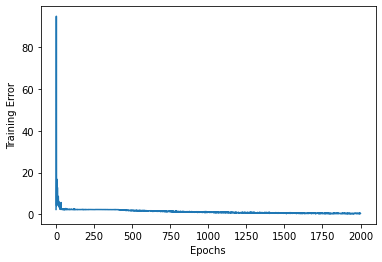

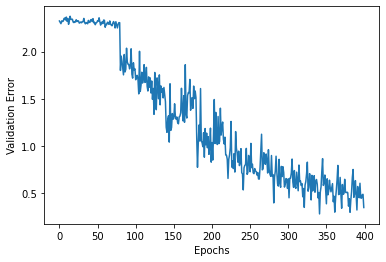

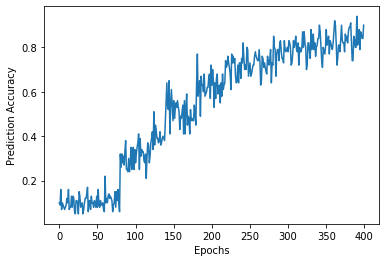

In [12]:
modelVGG = run_experiment(epochs=20)

# Confusion Matrix

In [17]:
accuracy , confusionMatrix = predictPyCNN(testDataLoader , modelVGG , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print('Accuracy on Test Data = {}%'.format(accuracy*100))
print('Confusion Matrix on Test Data')
print(confusionMatrix)

Accuracy on Test Data = 87.15999603271484%
Confusion Matrix on Test Data
[[444   1   7   1   3   1   0   2  28   5]
 [  3 469   0   0   0   1   1   0   5  17]
 [ 15   1 378  18  17  11  12   6   1   2]
 [  9   1  17 367  12  73  22   8   0   5]
 [  3   0  15  19 428   6   7  15   2   0]
 [  1   1   6  61  14 397   6  13   0   0]
 [  0   0  10  15  15   5 465   1   2   1]
 [  2   0   4  18   8  14   1 447   0   2]
 [ 10   2   1   6   1   0   0   1 480   5]
 [ 10  26   0   1   0   0   1   2   4 483]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


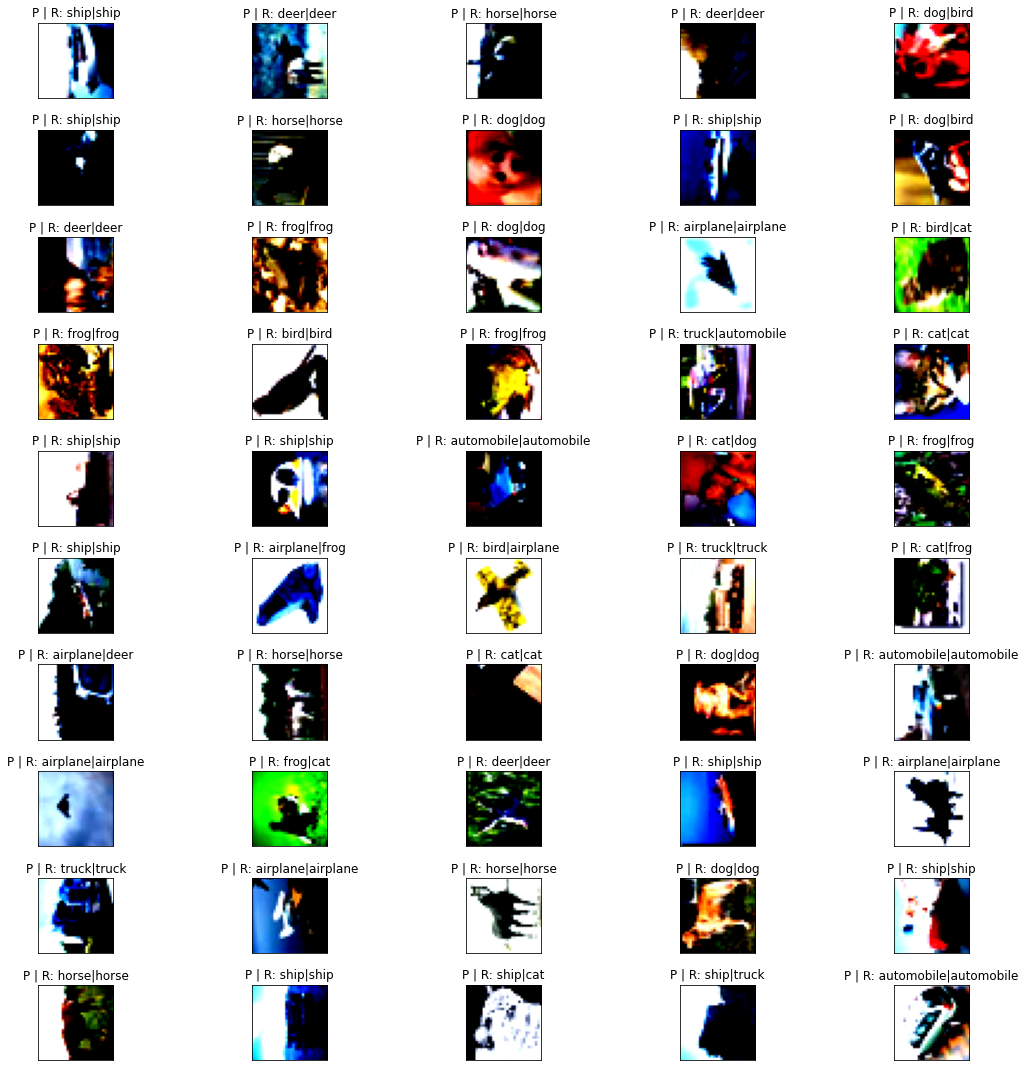

In [34]:
displayImages2(testData , modelVGG)

# Passing 5 Images downloaded from Internet

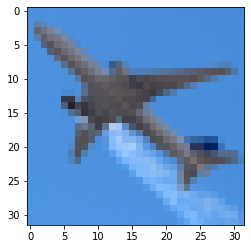

In [19]:
airplane = PIL.Image.open("/content/Airplane.png")
airplane = np.array(airplane.convert('RGB'))
plt.imshow(airplane)
plt.show()

In [22]:
image = test_transform(airplane)
temp = image.cpu()
image = torch.reshape(image , (1 , 3 , 32 , 32)).float()
image = image.to(device)
temp = torch.clamp(temp , 0 , 1)
out = modelVGG(image)
yPred = F.softmax(out , dim =1)
predictedNumber = torch.argmax(yPred , dim = 1)
print('Predicted Class -', outputLabel[int(predictedNumber)])

Predicted Class - airplane


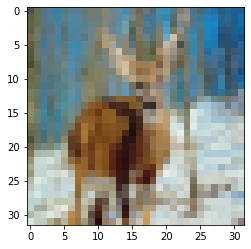

In [23]:
deer = PIL.Image.open("/content/Deer.png")
deer = np.array(deer.convert('RGB'))
plt.imshow(deer)
plt.show()

In [24]:
image = test_transform(deer)
temp = image.cpu()
image = torch.reshape(image , (1 , 3 , 32 , 32)).float()
image = image.to(device)
temp = torch.clamp(temp , 0 , 1)
out = modelVGG(image)
yPred = F.softmax(out , dim =1)
predictedNumber = torch.argmax(yPred , dim = 1)
print('Predicted Class -', outputLabel[int(predictedNumber)])

Predicted Class - deer


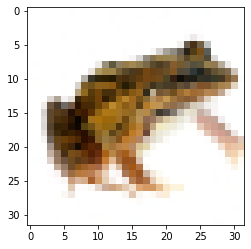

In [25]:
frog = PIL.Image.open("/content/Frog.png")
frog = np.array(frog.convert('RGB'))
plt.imshow(frog)
plt.show()

In [26]:
image = test_transform(frog)
temp = image.cpu()
image = torch.reshape(image , (1 , 3 , 32 , 32)).float()
image = image.to(device)
temp = torch.clamp(temp , 0 , 1)
out = modelVGG(image)
yPred = F.softmax(out , dim =1)
predictedNumber = torch.argmax(yPred , dim = 1)
print('Predicted Class -', outputLabel[int(predictedNumber)])

Predicted Class - frog


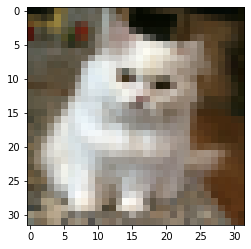

In [27]:
cat = PIL.Image.open("/content/cat.png")
cat = np.array(cat.convert('RGB'))
plt.imshow(cat)
plt.show()

In [28]:
image = test_transform(cat)
temp = image.cpu()
image = torch.reshape(image , (1 , 3 , 32 , 32)).float()
image = image.to(device)
temp = torch.clamp(temp , 0 , 1)
out = modelVGG(image)
yPred = F.softmax(out , dim =1)
predictedNumber = torch.argmax(yPred , dim = 1)
print('Predicted Class -', outputLabel[int(predictedNumber)])

Predicted Class - cat


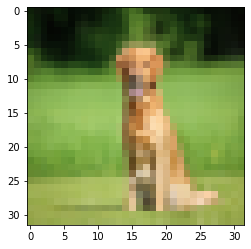

In [32]:
dog = PIL.Image.open("/content/dog.png")
dog = np.array(dog.convert('RGB'))
plt.imshow(dog)
plt.show()

In [33]:
image = test_transform(dog)
temp = image.cpu()
image = torch.reshape(image , (1 , 3 , 32 , 32)).float()
image = image.to(device)
temp = torch.clamp(temp , 0 , 1)
out = modelVGG(image)
yPred = F.softmax(out , dim =1)
predictedNumber = torch.argmax(yPred , dim = 1)
print('Predicted Class -', outputLabel[int(predictedNumber)])

Predicted Class - deer


# Observation

We can observe, almost all the random images were predicted correctly. 